# SwissFEL Gas-monitor HDF5

In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import os

## helper functions

TODO: At some point this should probably get wrapped into a class or a module

In [2]:
def sfel_gasmon_h5read(fname):
    varmap = {'SARFE10-PBIG050-EVR0:CALCI': 'CALCI',
              'SARFE10-PBIG050-EVR0:CALCS': 'CALCS',
              'SARFE10-PBIG050-EVR0:CALCT': 'CALCT',
              'SARFE10-PBPG050:FELPHOTENE': 'Ephot',
              'SARFE10-PBPG050:HAMP-HV-DS': 'Voltage_t',
              'SARFE10-PBPG050:HAMP-HV-US': 'Voltage_s',
              'SARFE10-PBPG050:MKS-PRESSURE': 'pressure',
              'SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-AVG': 'PEPavg',
              'pulse_id': 'pulse_id'}
    
    f = h5py.File(fname,'r')
    df = pd.DataFrame()
    for grp in f.keys():
        if grp == 'pulse_id':
            continue
        df[grp] = f.get(grp + '/data')[()]
    f.close()
    return df.rename(columns = varmap)

In [3]:
def sfel_gasmon_h5preproc(df, calc_thresh=50.0, interpolate=True):
    
    # first mark all missing data as NaN
    for col in ['Ephot', 'Voltage_s', 'Voltage_t', 'PEPavg','pressure']:
        df.loc[df.loc[:,col] == 0.0, col] = np.nan
    
    if interpolate:
        for col in ['Ephot', 'Voltage_s', 'Voltage_t', 'PEPavg','pressure']:
            df[col] = df[col].interpolate(method='linear') \
                             .fillna(method='backfill')
            # sometimes the initial rows of non-CALC columns contain NaN. This then
            # is missed by the previous interpolation. We backfill them in addition
            # to the interpolation
            
    # CALCS and CALCT are negative in raw data
    # TODO: base all calculations on positive CALC... I leave it for now
    #
    # enforce threshold
    for col in ['CALCS', 'CALCT']:
        df.loc[df.loc[:,col] > -calc_thresh, col] = np.nan
    # remove all missing CALC
    df = df[~(df.CALCS.isna() | df.CALCT.isna()) ]
    
    # in the original data sets I was given, the voltage was a positive number
    # in the raw data Voltages are negative
    df.Voltage_s = -df.Voltage_s
    df.Voltage_t = -df.Voltage_t
    
    # we want to have Ephot in eV, not in keV
    df.Ephot *= 1000
    
    return df[['CALCS', 'CALCT', 'PEPavg', 'Voltage_s', 'Voltage_t', 'Ephot', 'pressure']]

In [4]:
def sfel_gasmon_applymodel(df, model=None, s_or_t='s'):
    if s_or_t == 's':
        (calc, voltage) = 'CALCS','Voltage_s'
    else:
        (calc, voltage) = 'CALCT','Voltage_t'            
    return model(df[calc], df[voltage], df.Ephot)

In [5]:
def sfel_gasmon_plot_pepcompare(df, model=None, s_or_t='s'):
    fig = plt.figure(figsize=(12, 6*2))
    ax = fig.add_subplot(2,1,1)
    ax.plot(sfel_gasmon_applymodel(df, model=model, s_or_t=s_or_t), linestyle='', marker='.', alpha=0.05)
    ax.set_ylabel('predicted PEP')
    ax = fig.add_subplot(2,1,2)                 
    ax.plot(df.PEPavg, linestyle='', marker='.', alpha=0.05)
    ax.set_ylabel('avg. PEP based on current')

In [6]:
def sfel_gasmon_plot_cols(df, columns=None):
    if columns is None:
        columns = df.columns
    
    fig = plt.figure(figsize=(12, 6*len(columns)))
    for idx,col in enumerate(columns, start=1):
        ax = fig.add_subplot(len(columns),1,idx)    
        ax.plot(df[col], linestyle='', marker='.', alpha=0.05)
        ax.set_ylabel(col)

In [7]:
def sfel_gasmon_data_info(df):
    dfdict={}
    cols = ['Voltage_s', 'Voltage_t', 'Ephot', 'pressure', 'PEPavg', 'CALCS', 'CALCT' ]
    for col in cols:
        dfdict[col] = [df[col].min(), df[col].max()]
    return pd.DataFrame(dfdict).transpose().rename(columns={0: 'min', 1: 'max'})

## configuration

In [8]:
datadir = 'pavledata'

#filename='test1.h5'

datafiles = ['MLData_20200520_1.h5',
             'MLData_20200527_1.h5',
             'MLData_20200603_1.h5',
             'MLData_20200608_1.h5'
            ]

## Models
### Model factories

Classic EM gain model

\begin{aligned} {\text CALC} =  N_{\text {ph}} \cdot A \cdot V^{B} \end{aligned}

\begin{aligned}
N_{\text{ph, pulse}} = \frac{{\text {PEP}}_{\text {avg}}} {\hbar \omega}
\end{aligned}

\begin{aligned}
{\text {PEP}}_{\text {pred}} = \frac{{\text CALC} \cdot E_{\text {beam}}}{A V^{B}}
\end{aligned}


In [9]:
# classic EM gain model
def mk_pep_pred_EMgain(A, B):
    return lambda calc, voltage, ebeam: (1/6.241509e12) * ebeam * calc / (A * np.power(voltage, B))

EM gain model modulated by (1 + C * Ephot)

\begin{aligned} {\text CALC} = (1 + C \cdot E_{\text {beam}} ) \cdot N_{\text {ph}} \cdot A \cdot V^{B} \end{aligned}

\begin{aligned}
N_{\text{ph, pulse}} = \frac{{\text {PEP}}_{\text {avg}}} {\hbar \omega}
\end{aligned}

\begin{aligned}
{\text {PEP}}_{\text {pred}} = \frac{{\text CALC} \cdot E_{\text {beam}}}{(1 + C \cdot E_{\text {beam}}) A V^{B}}
\end{aligned}


In [10]:
# EM gain model modulated by (1 + C * Ephot)
def mk_pep_pred_EMgain_mod(A, B, C):
    return lambda calc, voltage, ebeam: (1/6.241509e12) * ebeam * calc / (1 + C * ebeam) / (A * np.power(voltage, B))

### Specific model implementations

Model 1: Based on cleaned calibration run data set and the classic EM gain model. Parametrized for CALCS

In [11]:
popt1 = [-8.12506079e-29,  6.54642197e+00]
pep_pred_fn1 = mk_pep_pred_EMgain(popt1[0], popt1[1])

Model 2: Based on cleaned calibration run data set and the by (1 + C * Ephot) empirically modulated EM gain model. Parametrized for CALCS.

In [12]:
popt2 = [-1.11290561e-29,  6.97740548e+00, -7.66814987e-05]
pep_pred_fn2 = mk_pep_pred_EMgain_mod(popt2[0], popt2[1], popt2[2])

## test

In [13]:
testfilename = datafiles[1]

In [14]:
df = sfel_gasmon_h5read(os.path.join(datadir,testfilename))

In [15]:
# This is the RAW data
df.describe()

CALCI          CALCS          CALCT          Ephot  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean     2113.019113   -2039.868987   -2186.172053       7.999194   
std       202.971933     194.922319     211.549033       0.107331   
min         0.000000   -2325.647480   -2485.751039       0.000000   
25%      2071.445260   -2121.975775   -2278.865581       8.000517   
50%      2145.076170   -2069.529503   -2220.582836       8.000639   
75%      2200.055481   -2000.845506   -2140.899989       8.000762   
max      2405.699259       0.000000       0.000000       8.001296   

           Voltage_t      Voltage_s       pressure         PEPavg  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean    -1421.718677   -1471.500578       0.000171     366.352101  
std        19.076263      19.744197       0.000002       5.561467  
min     -1422.170000   -1471.920000       0.000000       0.000000  
25%     -1422.010000   -1471.810000       0.000171     365.154884  
50%     -1421.970000   -1471.770000       0.000171     366.410661  
75%     -1421.930000   -1471.740000       0.000172     367.684191  
max         0.000000       0.000000       0.000172     376.327579

In [16]:
df = sfel_gasmon_h5preproc(df)

/opt/psi/Programming/anaconda/2019.07/conda/envs/datascience_py37/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
# this is the preprocessed data
df.describe()

CALCS         CALCT        PEPavg     Voltage_s     Voltage_t  \
count  99324.000000  99324.000000  99324.000000  99324.000000  99324.000000   
mean   -2053.752353  -2201.051159    366.418749   1471.765478   1421.974624   
std       98.691554    110.939546      2.603052      0.052397      0.059635   
min    -2325.647480  -2485.751039    358.946026   1471.560000   1421.820000   
25%    -2122.366619  -2279.275981    365.154884   1471.740000   1421.930000   
50%    -2070.215357  -2221.415879    366.410661   1471.770000   1421.970000   
75%    -2002.644024  -2143.028135    367.684191   1471.810000   1422.010000   
max    -1173.345368  -1186.036732    376.327579   1471.920000   1422.170000   

              Ephot      pressure  
count  99324.000000  9.932400e+04  
mean    8000.633920  1.712302e-04  
std        0.210306  8.124049e-07  
min     8000.026400  1.686584e-04  
25%     8000.516824  1.714374e-04  
50%     8000.639432  1.714706e-04  
75%     8000.762041  1.715968e-04  
max     8001.296083  1.719577e-04

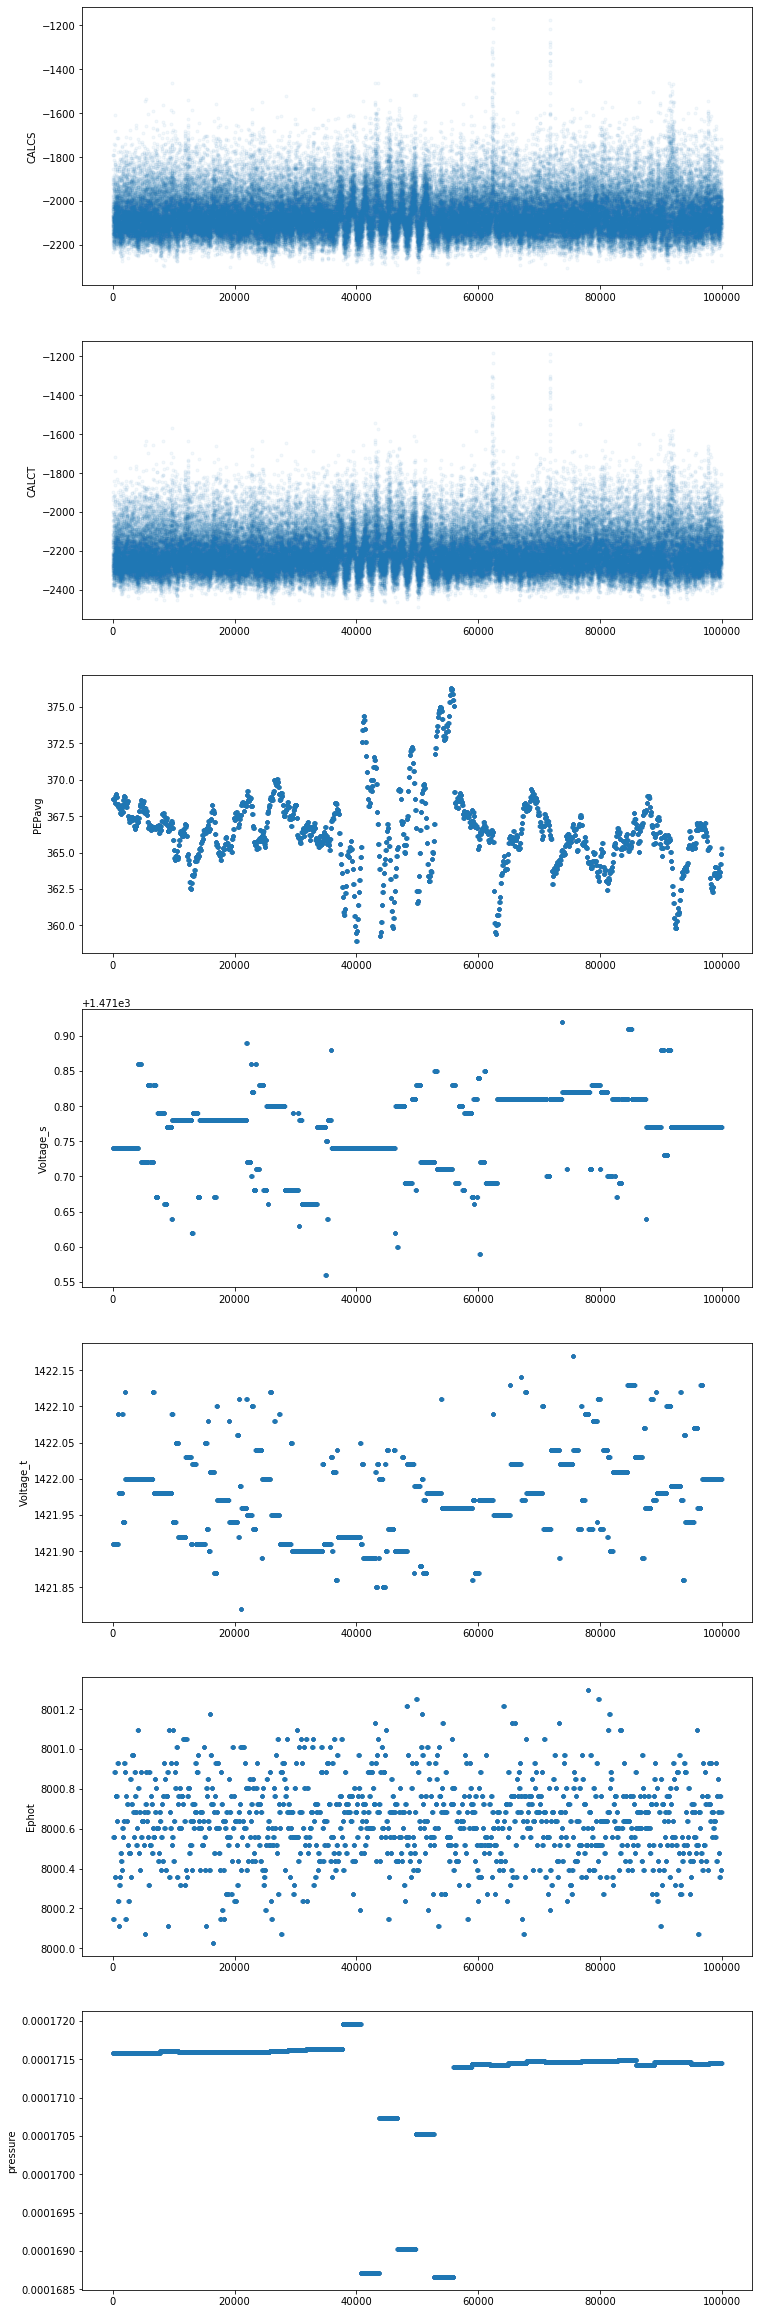

In [18]:
sfel_gasmon_plot_cols(df)

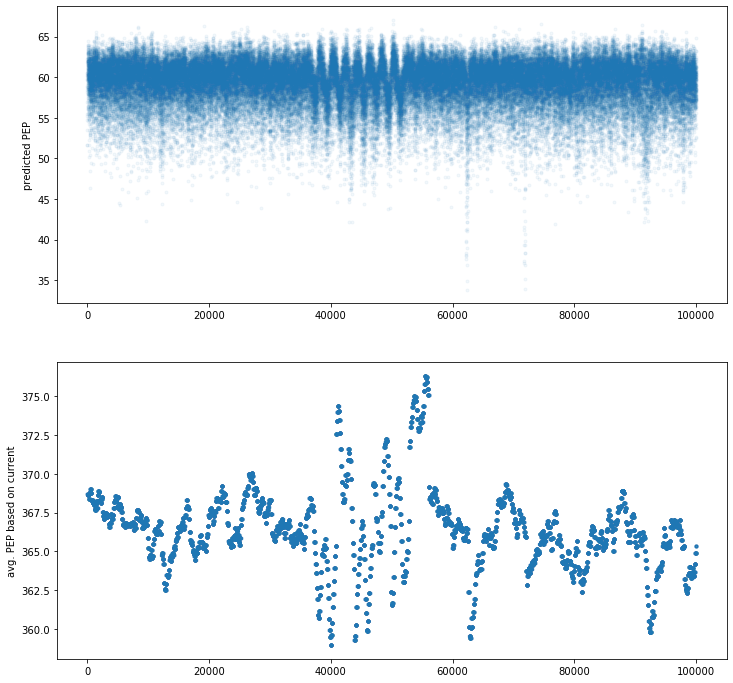

In [19]:
sfel_gasmon_plot_pepcompare(df, model=pep_pred_fn1, s_or_t='s')

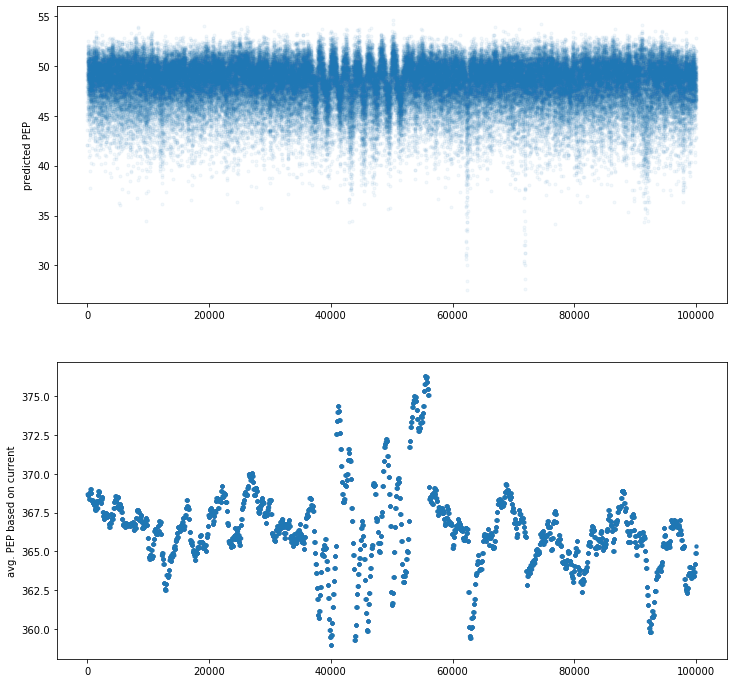

In [20]:
sfel_gasmon_plot_pepcompare(df, model=pep_pred_fn2, s_or_t='s')

# Analysis of new Data beginning from 2020 May

## a

In [21]:
fname = datafiles[0]
print(f'Datafile: {fname}')

Datafile: MLData_20200520_1.h5


In [22]:
df = sfel_gasmon_h5read(os.path.join(datadir,fname))
df = sfel_gasmon_h5preproc(df)

In [23]:
sfel_gasmon_data_info(df)

min          max
Voltage_s  1571.560000  1571.950000
Voltage_t  1571.770000  1572.160000
Ephot      9884.052075  9885.635391
pressure      0.000151     0.000155
PEPavg      184.703446   204.990310
CALCS     -1173.600440  -578.016505
CALCT      -984.102109  -497.494823

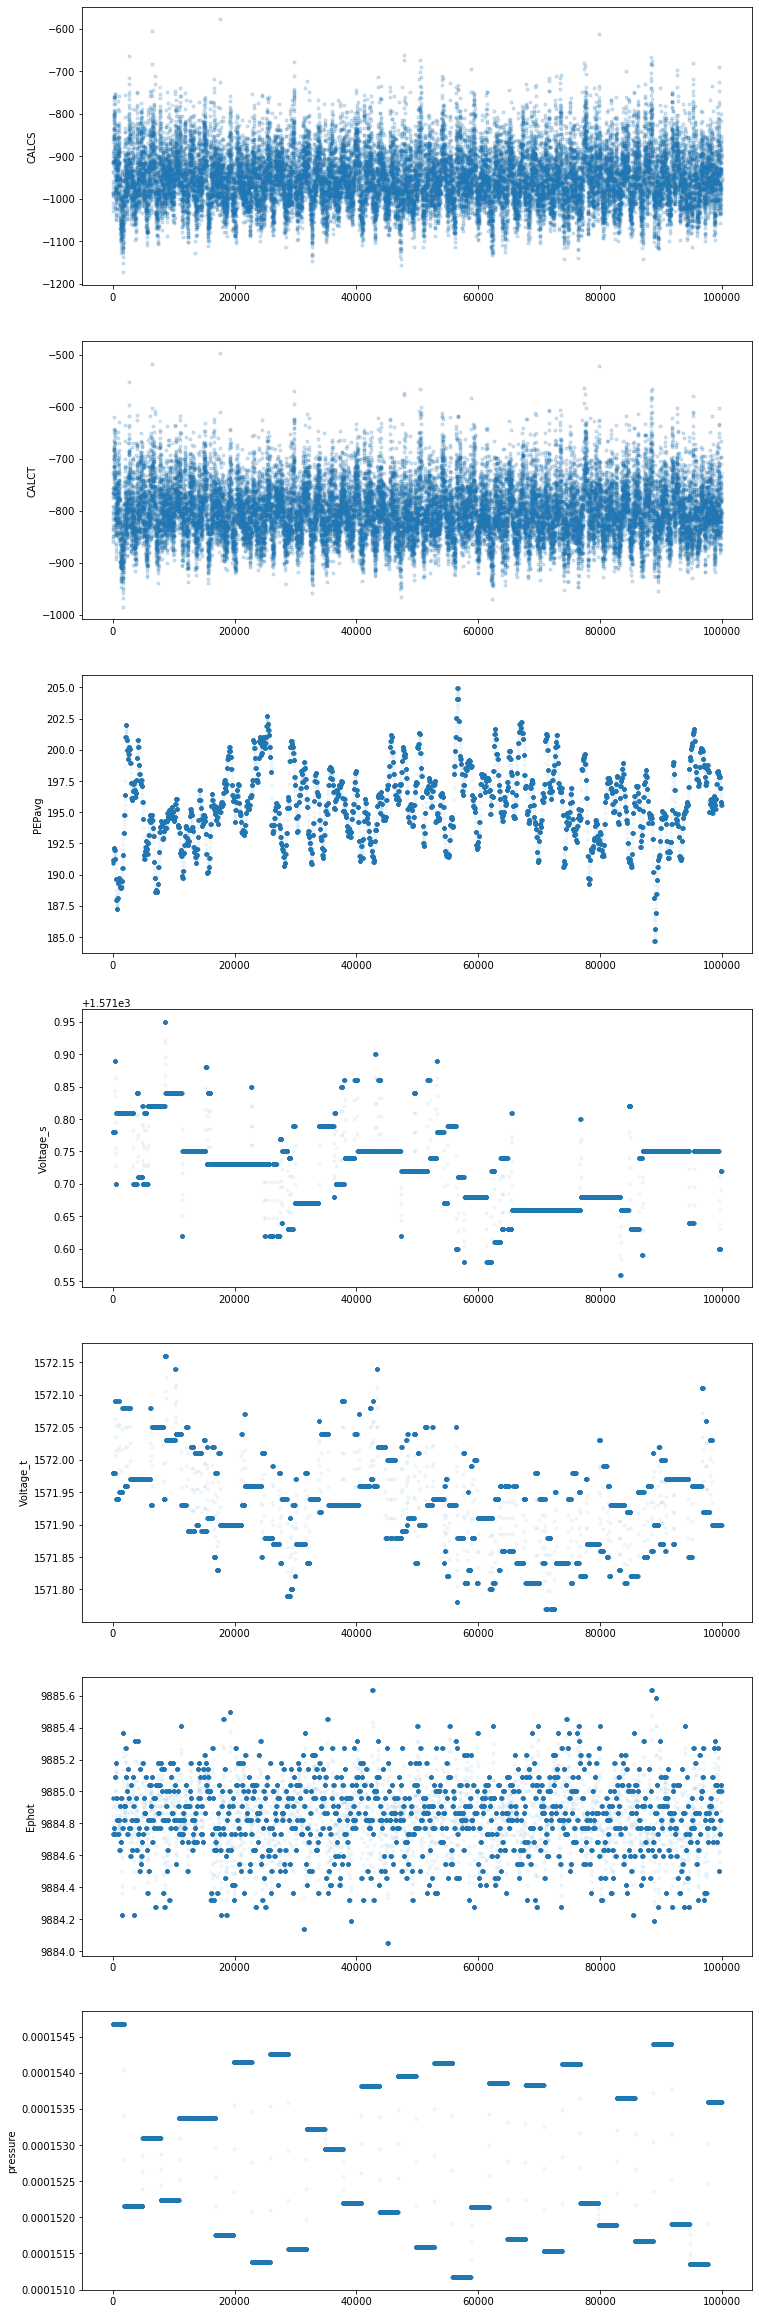

In [24]:
sfel_gasmon_plot_cols(df)

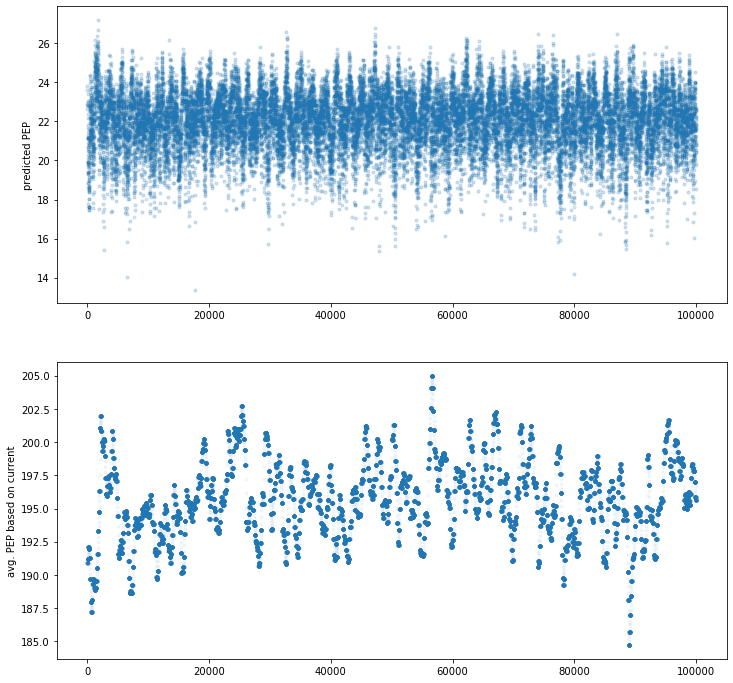

In [25]:
sfel_gasmon_plot_pepcompare(df, model=pep_pred_fn1, s_or_t='s')

## b

In [26]:
fname = datafiles[1]
print(f'Datafile: {fname}')

Datafile: MLData_20200527_1.h5


In [27]:
df = sfel_gasmon_h5read(os.path.join(datadir,fname))
df = sfel_gasmon_h5preproc(df)

In [28]:
sfel_gasmon_data_info(df)

min          max
Voltage_s  1471.560000  1471.920000
Voltage_t  1421.820000  1422.170000
Ephot      8000.026400  8001.296083
pressure      0.000169     0.000172
PEPavg      358.946026   376.327579
CALCS     -2325.647480 -1173.345368
CALCT     -2485.751039 -1186.036732

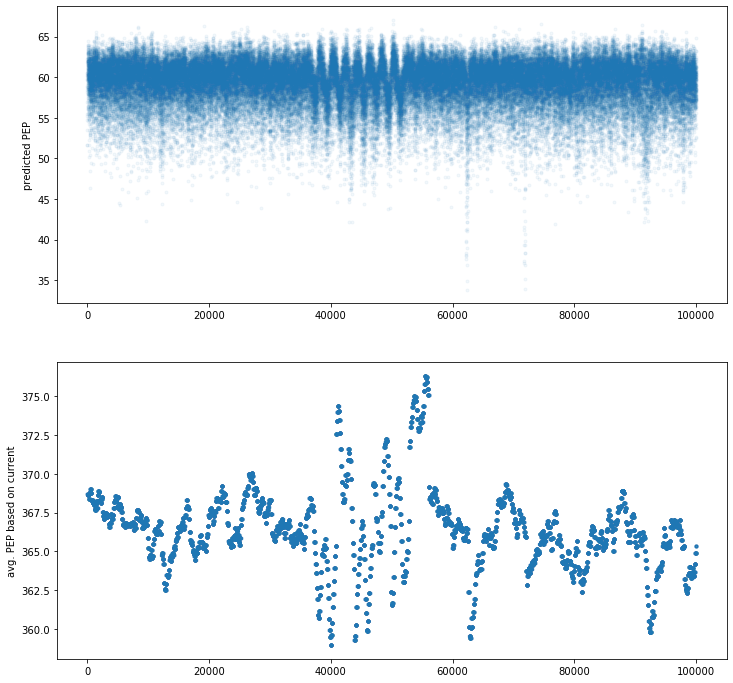

In [29]:
sfel_gasmon_plot_pepcompare(df, model=pep_pred_fn1, s_or_t='s')

## c

In [30]:
fname = datafiles[2]
print(f'Datafile: {fname}')

Datafile: MLData_20200603_1.h5


In [31]:
df = sfel_gasmon_h5read(os.path.join(datadir,fname))
df = sfel_gasmon_h5preproc(df)

In [32]:
sfel_gasmon_data_info(df)

min          max
Voltage_s  1521.630000  1521.930000
Voltage_t  1471.770000  1472.110000
Ephot      7999.976115  8001.405192
pressure      0.000169     0.000172
PEPavg      329.252828   368.472727
CALCS     -2785.418403 -1381.756069
CALCT     -3008.075127 -1499.992820

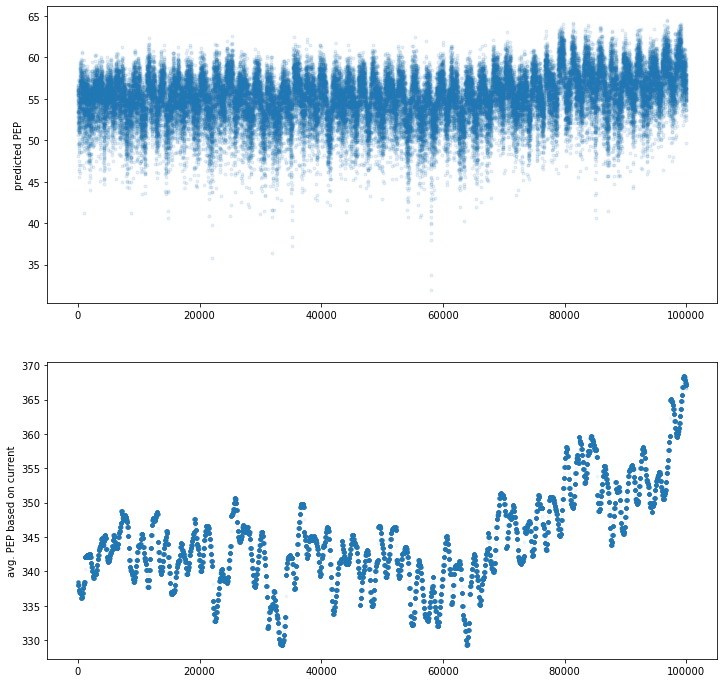

In [33]:
sfel_gasmon_plot_pepcompare(df, model=pep_pred_fn1, s_or_t='s')

## d

In [38]:
fname = datafiles[3]
print(f'Datafile: {fname}')

Datafile: MLData_20200608_1.h5


In [39]:
df = sfel_gasmon_h5read(os.path.join(datadir,fname))
df = sfel_gasmon_h5preproc(df)

In [40]:
sfel_gasmon_data_info(df)

min          max
Voltage_s  1471.610000  1471.870000
Voltage_t  1421.770000  1422.120000
Ephot      7999.976115  8001.324812
pressure      0.000167     0.000175
PEPavg      378.640406   417.950804
CALCS     -2612.543566 -1217.230589
CALCT     -2659.088429 -1156.083516

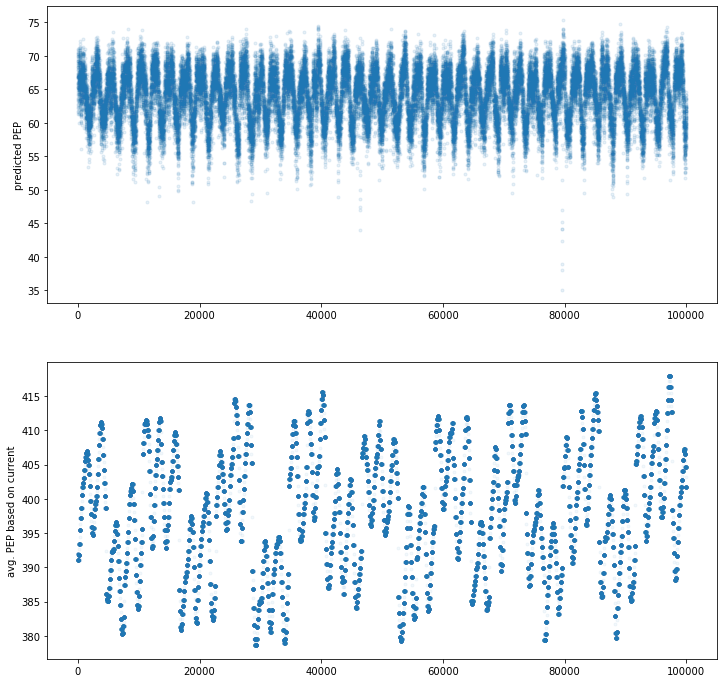

In [41]:
sfel_gasmon_plot_pepcompare(df, model=pep_pred_fn1, s_or_t='s')